In [2]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Image cleaning

**Author(s):**
 - Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

**Description:**

This notebook contains DL1-image-cleaning plots and benchmark proposals from the _protopipe_ pipeline.  
This was mainly triggered by the step-by-step comparison against _CTA-MARS_, but it can be extended to other pipelines as well.  
**NOTE** Let's try to follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding those benchmarks or proposing new ones.  
**WARNING** Contrary to the calibration notebook, I am still working on this one, so it's a bit messy and incomplete!

**Requirements:**

To run this notebook you will need a DL1 file generated using _protopipe.scripts.data_training.py_ .  
Reference simtel-files, plots, values and settings can be found [here (please, always refer to the latest version)](https://forge.in2p3.fr/projects/benchmarks-reference-analysis/wiki/Comparisons_between_pipelines) until we have a more automatic and fancy approach (aka [cta-benchmarks](https://github.com/cta-observatory/cta-benchmarks)+[ctaplot](https://github.com/cta-observatory/ctaplot)).  

The data format required to run the notebook is the current one used by _protopipe_ . Soon it will be the same as in _ctapipe_ . 

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.

**TODO:**
* add missing plots in section [Total image charge ("Intensity") resolution for selected images"](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#Total-image-charge-Intensity-resolution-for-selected-images)

## Table of contents
  - [Fraction of events (relative to telescope triggers) that survive a given intensity cut](#Fraction-of-events-(relative-to-telescope-triggers)-that-survive-a-given-intensity-cut)
  - [Image-parameter distributions](#Image-parameter-distributions)

## Imports

In [3]:
import os
import tables
from pathlib import Path
import numpy as np
import pandas
import uproot
from scipy.stats import binned_statistic, binned_statistic_2d, cumfreq, percentileofscore
from astropy import units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

from ctapipe.instrument import OpticsDescription
from ctapipe.image.hillas import camera_to_shower_coordinates

## Functions

In [4]:
def get_camera_names(infile = None):
    """Read the names of the cameras.
    
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    
    Returns
    =======
    camera_names : list(str)
        Table names as a list.
    """
    if infile is None:
        print("ERROR: no input file specified")
    h5file = tables.open_file(infile, mode='r')
    group = h5file.get_node("/")
    camera_names = [x.name for x in group._f_list_nodes()]
    h5file.close()
    return camera_names

In [5]:
def load_reset_dl1_pandas(infile = None, camera_names=None):
    """(Re)load the file containing DL1(a) data and extract the data per telescope type.
     
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    
    Returns
    =======
    dataFrames : dict(pandas.DataFrame)
        Dictionary of tables per camera.
    """
    if infile is None:
        print("ERROR: no input file specified")
    if camera_names is None:
        print("ERROR: no cameras specified")
    # load DL1 images
    dataFrames = {camera : pandas.read_hdf(f"{indir}/{fileName}", f"/{camera}") for camera in camera_names}
    return dataFrames

In [6]:
def read_dl1_quantities(data):
    """Get DL1 quantities as arrays from a camera table."""
    
    dictionary = {

            "Intensity [#phe]"   : data["hillas_intensity_reco"],
            "Width [m]"          : data["hillas_width_reco"],
            "Length [m]"         : data["hillas_length_reco"],
            "Skewness"           : data["hillas_skewness"],
            "Kurtosis"           : data["hillas_kurtosis"],
            "H_max [m]"          : data["h_max"],
            "n_pixel"            : data["pixels"],
            "Ellipticity"        : data["hillas_ellipticity"],
            "Leakage 1"          : data["leakage_intensity_width_1_reco"],
            "psi"                : data["hillas_psi_reco"],
            "cog_x"              : data["hillas_x_reco"],
            "cog_y"              : data["hillas_y_reco"],
            "cog_r"              : data["hillas_r_reco"],
        }
    
    return dictionary

In [7]:
def add_stats(x, ax):
    """Add a textbox containing statistical information."""
    mu = x.mean()
    median = x.median()
    sigma = x.std()
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.70, 0.85, 
            textstr, 
            transform=ax.transAxes, 
            fontsize=10,
            horizontalalignment='left',
            verticalalignment='center', 
            bbox=props)

## Input data
[back to top](#Table-of-contents)

### Protopipe
[back to top](#Table-of-contents)

In [8]:
config = "test" # suffix for all plots

In [9]:
# Please, make sure these variables are empty before pushing any modification
indir = ""
fileName = ""

infile = os.path.join(indir,fileName)

In [10]:
cameras = get_camera_names(infile)

In [11]:
# fill with the correct path, filename of the generated file in your system
data = load_reset_dl1_pandas(infile = infile, camera_names=cameras)

### CTA-MARS
[back to top](#Table-of-contents)

In [12]:
average_camera_radii_deg = {
        "ASTRICam": 4.67,
        "CHEC": 3.93,
        "DigiCam": 4.56,
        "FlashCam": 3.95,
        "NectarCam": 4.05,
        "LSTCam": 2.31,
        "SCTCam": 4.0,  # dummy value
    }

In [13]:
# where is the CTAMARS ROOT file (do not change this information)
indir_refData = "./reference_data"
mars_dl1b_fileName = "CTA-MARS/check_dl1b.root"
path_mars_dl1b = os.path.join(indir_refData, mars_dl1b_fileName)

In [14]:
# read CTAMARS ROOT file
ctamars_dl1b = uproot.open(path_mars_dl1b)
# ctamars_dl1b.allkeys()

In [15]:
mars_size_WL_LSTCam = ctamars_dl1b["log10Size_WL_type0"].numpy()
mars_size_WL_NectarCam = ctamars_dl1b["log10Size_WL_type1"].numpy()
mars_size_d80_LSTCam = ctamars_dl1b["log10Size_d80_type0"].numpy()
mars_size_d80_NectarCam = ctamars_dl1b["log10Size_d80_type1"].numpy()

CTAMARS = {}
CTAMARS["LSTCam"] = {"size_WL" : mars_size_WL_LSTCam, "size_d80":mars_size_d80_LSTCam}
CTAMARS["NectarCam"] = {"size_WL" : mars_size_WL_NectarCam, "size_d80":mars_size_d80_NectarCam}

## Plots and benchmarks
[back to top](#Table-of-contents)

In [16]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
Path("./plots_image_cleaning").mkdir(parents=True, exist_ok=True)

### Fraction of events (relative to telescope triggers) that survive a given intensity cut
[back to top](#Table-of-contents)

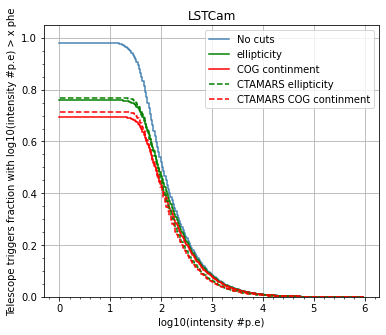

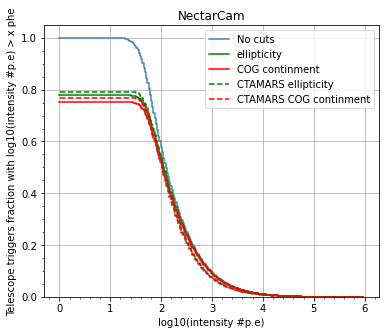

In [41]:
nbins = 250
xrange = [0,6]

for camera in cameras:
    
    fig = plt.figure(figsize=(6, 5), tight_layout=False)
    plt.xlabel("log10(intensity #p.e)")
    plt.ylabel("Telescope triggers fraction with log10(intensity #p.e) > x phe")
    plt.title(camera)

    tot_entries = len(data[camera]["hillas_intensity_reco"])

    # No cuts
    DL1_filtered = data[camera].loc[:]
    intensity_hist, xbins = np.histogram( np.log10(DL1_filtered["hillas_intensity_reco"]), bins=nbins, range=xrange)
    plt.plot(xbins[:-1], intensity_hist[::-1].cumsum()[::-1]/tot_entries, drawstyle="steps-post", label="No cuts", color="steelblue")
    
    # Cut in the number of pixels
    #DL1_filtered = data[camera].loc[data[camera]['pixels'] > 3]
    #intensity_hist, xbins = np.histogram( np.log10(DL1_filtered["hillas_intensity_reco"]), bins=nbins, range=xrange)
    #plt.plot(xbins[:-1], intensity_hist[::-1].cumsum()[::-1]/tot_entries, drawstyle="steps-post", label="n_pixel")
    
    # Cut in ellipticity
    DL1_filtered = DL1_filtered.loc[(data[camera]['hillas_ellipticity_reco'] > 0.1) & (data[camera]['hillas_ellipticity_reco'] < 0.6)]
    intensity_hist, xbins = np.histogram( np.log10(DL1_filtered["hillas_intensity_reco"]), bins=nbins, range=xrange)
    plt.plot(xbins[:-1], intensity_hist[::-1].cumsum()[::-1]/tot_entries, drawstyle="steps-post", label="ellipticity", color="green")
    
    # Cut in containment radius
    DL1_filtered = DL1_filtered.loc[data[camera]['hillas_r_reco'] < (average_camera_radii_deg[camera]*0.8)]
    intensity_hist, xbins = np.histogram( np.log10(DL1_filtered["hillas_intensity_reco"]), bins=nbins, range=xrange)
    plt.plot(xbins[:-1], intensity_hist[::-1].cumsum()[::-1]/tot_entries, drawstyle="steps-post", label="COG continment", color="red")

    # Plot CTAMARS data

    x = 0.5 * (CTAMARS[camera]["size_WL"][1][1:] + CTAMARS[camera]["size_WL"][1][:-1])
    plt.step(x, CTAMARS[camera]["size_WL"][0], where='mid', label='CTAMARS ellipticity', color="green", linestyle="--")
    plt.step(x, CTAMARS[camera]["size_d80"][0], where='mid', label='CTAMARS COG continment', color="red", linestyle="--")
    
    plt.ylim([0.,1.05])
    plt.minorticks_on()
    plt.grid()
    plt.legend()

    fig.savefig(f"./plots_image_cleaning/eventsAboveIntensity_{camera}_protopipe_{config}.png")

### Image-parameter distributions
[back to top](#Table-of-contents)

**Notes**  
 - probably better to make bins in energy
 - the parameters should be at least those that enter the estimators training (here only the pure DL1 are listed)

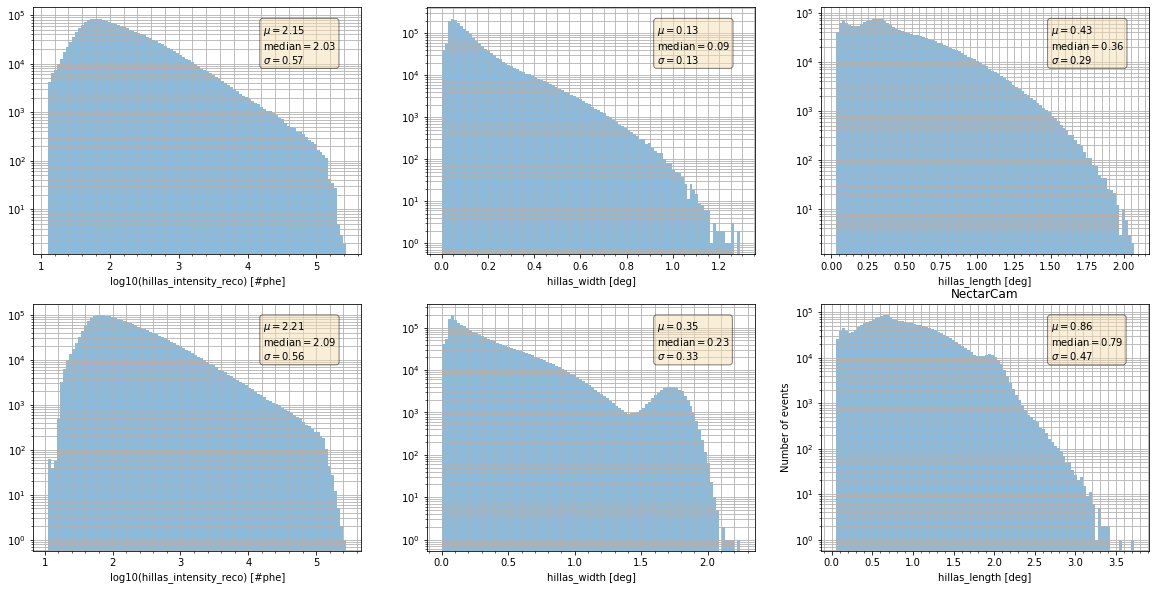

In [45]:
nbins = 100
parameters_to_plot = ["hillas_intensity_reco", "hillas_width", "hillas_length"]

fig, axes = plt.subplots(ncols=len(parameters_to_plot), nrows=len(cameras), constrained_layout=False, figsize = (20, 10))

for i, camera in enumerate(cameras):
        
    for j, key in enumerate(parameters_to_plot):
        
        plt.ylabel("Number of events")
        plt.title(camera)

        if key == "hillas_intensity_reco":
            axes[i, j].set_xlabel(f"log10({key}) [#phe]")
            axes[i, j].hist(np.log10(data[camera][key]), bins=nbins, alpha = 0.5)
            add_stats(np.log10(data[camera][key]), axes[i, j])
        else:
            axes[i, j].set_xlabel(f"{key} [deg]")
            axes[i, j].hist(data[camera][key], bins=nbins, alpha = 0.5)
            add_stats(data[camera][key], axes[i, j])

        axes[i, j].set_yscale('log')
        axes[i, j].minorticks_on()
        axes[i, j].grid(which = "both")
        
        fig.savefig(f"./plots_image_cleaning/{key}_{camera}_protopipe_{config}.png")